## 데이터 불러오기

([], [])

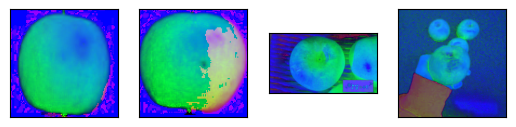

In [1]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

path = "./apples/"
top_d, mid_d, low_d, wat_d = [], [], [], []

for category in os.listdir(path):
    try:
        for file in os.listdir(os.path.join(path, category)):
            try:
                img = cv.imread(os.path.join(path, category, file))
                img = cv.cvtColor(img, cv.COLOR_BGR2HSV)
                
                if category == "top": top_d.append(img)
                elif category == "mid": mid_d.append(img)
                elif category == "low": low_d.append(img)
                elif category == "wat": wat_d.append(img)
            except: continue
    except: continue

plt.subplot(1, 4, 1); plt.imshow(top_d[10]); plt.xticks([]); plt.yticks([])
plt.subplot(1, 4, 2); plt.imshow(mid_d[10]); plt.xticks([]); plt.yticks([])
plt.subplot(1, 4, 3); plt.imshow(low_d[10]); plt.xticks([]); plt.yticks([])
plt.subplot(1, 4, 4); plt.imshow(wat_d[10]); plt.xticks([]); plt.yticks([])

## 전처리

### 일정한 비율로 이미지 크기 및 패딩 조절

In [2]:
def ImageScale(img, scale_sized):
    height, width = img.shape[:2]
    aspect_ratio = width / height

    if aspect_ratio > 1:
        new_width = scale_sized
        new_height = int(new_width / aspect_ratio)
    else:
        new_height = scale_sized
        new_width = int(new_height / aspect_ratio)

    resized_img = cv.resize(img, (new_width, new_height))

    delta_w = scale_sized - new_width
    delta_h = scale_sized - new_height
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    padded_img = cv.copyMakeBorder(resized_img, top, bottom, left, right, cv.BORDER_CONSTANT, value=(255, 255, 255))
    return padded_img

In [3]:
scale_sized = 128
top_d_scaled, mid_d_scaled, low_d_scaled, wat_d_scaled = [], [], [], []

for img in top_d:
    try: top_d_scaled.append(ImageScale(img, scale_sized)) 
    except: continue

for img in mid_d:
    try: mid_d_scaled.append(ImageScale(img, scale_sized))
    except: continue

for img in low_d:
    try: low_d_scaled.append(ImageScale(img, scale_sized))
    except: continue

for img in wat_d:
    try: wat_d_scaled.append(ImageScale(img, scale_sized))
    except: continue

In [4]:
X = np.array(top_d_scaled + mid_d_scaled + low_d_scaled + wat_d_scaled)
y = np.array(["top"] * len(top_d_scaled) + ["mid"] * len(mid_d_scaled) + ["low"] * len(low_d_scaled) + ["wat"] * len(wat_d_scaled))

print(X.shape, y.shape)

(1613, 128, 128, 3) (1613,)


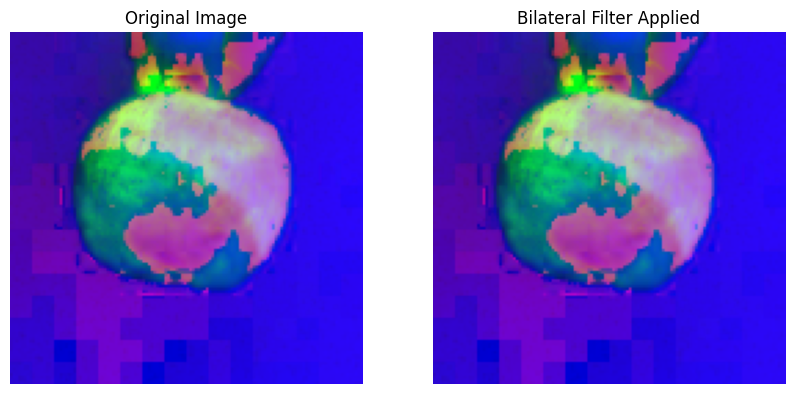

In [5]:
filtered_imgs = []
for img in X:
    img = cv.bilateralFilter(img, d=5, sigmaColor=15, sigmaSpace=15)
    filtered_imgs.append(img)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(X[1000])
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Bilateral Filter Applied")
plt.imshow(X[1000])
plt.axis('off')
plt.show()

X_filtered = np.array(filtered_imgs)

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, train_size=0.8, shuffle=True, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1290, 128, 128, 3) (323, 128, 128, 3) (1290,) (323,)


### 데이터 불균형으로 인한 오버샘플링 - SMOTE

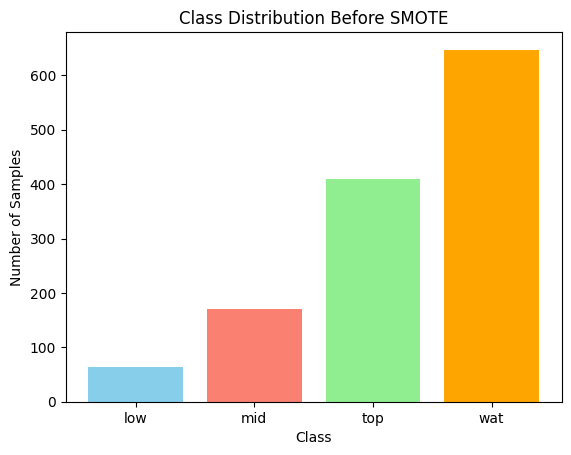

In [7]:
unique_classes_resampled, class_counts_resampled = np.unique(y_train, return_counts=True)
colors = ["skyblue", "salmon", "lightgreen", "orange"]

plt.bar(unique_classes_resampled, class_counts_resampled, color=colors)
plt.title('Class Distribution Before SMOTE')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(unique_classes_resampled)
plt.show()


In [8]:
from imblearn.over_sampling import SMOTE

X_train_flatten = X_train.reshape(X_train.shape[0], -1)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_flatten, y_train)

X_smote_reshaped = X_train_smote.reshape(X_train_smote.shape[0], X_train.shape[1], X_train.shape[2], X_train.shape[3])
print(X_smote_reshaped.shape, y_train_smote.shape)

(2588, 128, 128, 3) (2588,)


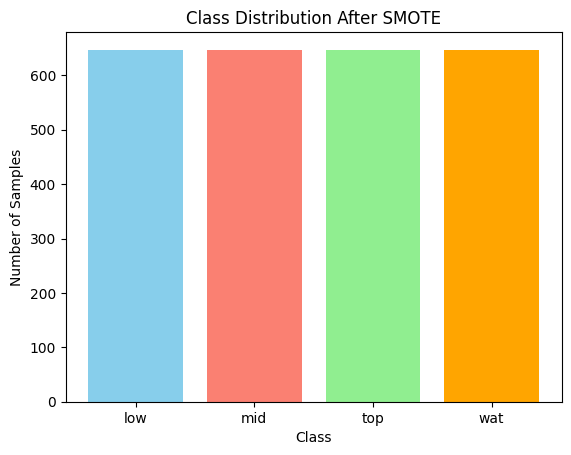

In [9]:
# SMOTE 이후 라벨 데이터의 클래스 분포
unique_classes_resampled, class_counts_resampled = np.unique(y_train_smote, return_counts=True)

# 시각화
plt.bar(unique_classes_resampled, class_counts_resampled, color=colors)
plt.title('Class Distribution After SMOTE')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(unique_classes_resampled)  # 클래스 값 표시
plt.show()


### 훈련데이터 이미지 증강

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

generator = ImageDataGenerator(
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True
)

augmented_X = []; augmented_Y = []
for i, (image, label) in enumerate(zip(X_smote_reshaped, y_train_smote)):
    count = 0
    for batch in generator.flow(np.expand_dims(image, axis=0), batch_size=1):
        augmented_X.append(batch[0])
        augmented_Y.append(label)

        count += 1
        if count == 15: break

X_train = np.concatenate([X_smote_reshaped, augmented_X], axis=0)
y_train = np.concatenate([y_train_smote, augmented_Y], axis=0)
print(X_train.shape, y_train.shape) # 증강된 이미지 개수 + 원본 이미지 개수

(41408, 128, 128, 3) (41408,)


### 라벨 인코딩

In [11]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

### 이미지 3차원 -> 1차원

In [12]:
# 1차원 배열 X_train과 X_test 생성!
X_v_train = X_train.reshape(X_train.shape[0], -1)
X_v_test = X_test.reshape(X_test.shape[0], -1)

print(X_v_train.shape, X_v_test.shape)

(41408, 49152) (323, 49152)


In [13]:
# 이미지 정규화
X_train = X_train.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0

X_v_train = X_v_train.astype("float32") / 255.0
X_v_test = X_v_test.astype("float32") / 255.0

In [14]:
# 랜덤 인덱스 생성
indices = np.arange(len(X_train))
np.random.shuffle(indices)

# 같은 순서로 셔플
X_train = X_train[indices]
y_train = y_train[indices]

## 모델학습

### LinearRegression

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

best_accuracy = 0; accuracys = []; best = None; k=5
for train_idx, val_idx in KFold(k).split(X_v_train):
    xtrain, xval = X_v_train[train_idx], X_v_train[val_idx]
    ytrain, yval = y_train[train_idx], y_train[val_idx]

    lr_model = LogisticRegression(solver="lbfgs", multi_class="multinomial")
    lr_model.fit(xtrain, ytrain)

    y_pred = lr_model.predict(xval)
    accuracy = accuracy_score(y_pred, yval)

    accuracys.append(accuracy)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best = lr_model

C:\Users\SiHyun\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\SiHyun\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\U

In [16]:
print(accuracys)
print(f"LogisticRegression Accuracy avg: {np.average(accuracys)}")

[0.24619657087659985, 0.2503018594542381, 0.23991789422844723, 0.24876222678420482, 0.2488829851467214]
LogisticRegression Accuracy avg: 0.2468123072980423


Best LinearRegression Acc: 0.21052631578947367


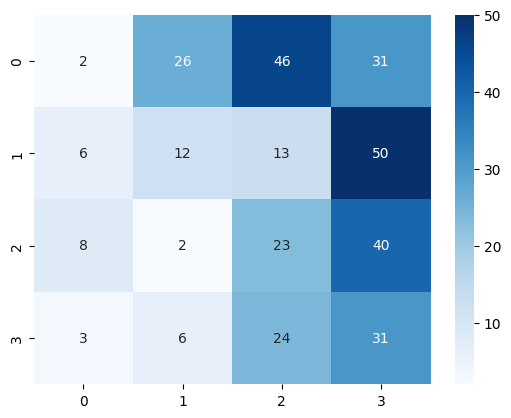

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = best.predict(X_v_test)

cm = confusion_matrix(y_pred, y_test)
sns.heatmap(cm, cmap="Blues", annot=True, fmt="d")

print(f"Best LinearRegression Acc: {accuracy_score(y_pred, y_test)}")

### XGBoost

In [18]:
# from xgboost import XGBClassifier

# model = XGBClassifier(use_label_encoder=True, eval_metric='mlogloss')
# model.fit(X_v_train, y_train)
# accuracy = model.score(X_v_test, y_test)
# print("XGBoost Accuracy:", accuracy)

### DecisionTree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

# 파라미터 범위 정의
param_dist = {
    'criterion': ['gini', 'entropy'],         # 분할 기준
    'max_depth': [None, 5, 10, 15, 20],       # 트리 최대 깊이
    'min_samples_split': [2, 5, 10],          # 노드 분할 최소 샘플 수
    'min_samples_leaf': [1, 2, 5, 10],        # 리프 노드 최소 샘플 수
    'max_features': [None, 'sqrt', 'log2'],   # 사용할 최대 특성 수
}

# 모델 정의
dt = DecisionTreeClassifier(random_state=42)

# RandomizedSearchCV 설정
random_search = RandomizedSearchCV(
    estimator=dt,
    param_distributions=param_dist,
    n_iter=20,  # 탐색할 조합 수
    scoring='accuracy',  # 평가 기준
    cv=5,  # 교차검증 Fold 수
    random_state=42,
    verbose=1
)

# 학습
random_search.fit(X_v_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred = random_search.predict(X_v_test)

print(f"DecisionTree Classification: {accuracy_score(y_pred, y_test)}")

cm = confusion_matrix(y_pred, y_test)
sns.heatmap(cm, cmap="Blues", annot=True, fmt="d")

### Convolutional Neural Networks

In [31]:
from tensorflow.keras import layers, models
from tensorflow.keras.utils import plot_model
# from tensorflow.keras import regularizers

def cnnModel():
    cnn = models.Sequential()
    cnn.add(layers.Conv2D(16, (3, 3), activation="relu", input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])))
    cnn.add(layers.MaxPooling2D((2, 2)))

    cnn.add(layers.Conv2D(32, (3, 3), activation="relu"))
    cnn.add(layers.MaxPooling2D((2, 2)))

    cnn.add(layers.Conv2D(64, (3, 3), activation="relu"))
    cnn.add(layers.MaxPooling2D((2, 2)))
    cnn.add(layers.Flatten())

    cnn.add(layers.Dense(32, activation="relu"))
    cnn.add(layers.BatchNormalization())
    cnn.add(layers.Dropout(0.2))

    cnn.add(layers.Dense(16, activation="relu"))
    cnn.add(layers.BatchNormalization())
    cnn.add(layers.Dropout(0.2))
    
    cnn.add(layers.Dense(len(np.unique(y_train)), activation="softmax"))

    plot_model(cnn, to_file='model_structure.png', show_shapes=True, show_layer_names=True, dpi=150, rankdir='LR')
    return cnn

In [32]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold

early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

best_accuracy = 0; accuracys = []; 
best_history = None; best = None; k = 5
for train_idx, val_idx in KFold(k).split(X_train):
    xtrain, xval = X_train[train_idx], X_train[val_idx]
    ytrain, yval = y_train[train_idx], y_train[val_idx]

    cnn = cnnModel()
    cnn.compile(optimizer=Adam(learning_rate=0.0001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    history = cnn.fit(xtrain, ytrain, epochs=20, batch_size=16, validation_data=(xval, yval), callbacks=[early_stopping], verbose=1)

    accuracy = cnn.evaluate(xval, yval, verbose=0)[1]

    accuracys.append(accuracy)
    if(best_accuracy < accuracy):
        best_accuracy = accuracy; 
        best_history = history
        best = cnn

You must install pydot (`pip install pydot`) for `plot_model` to work.
Epoch 1/20
2071/2071 ━━━━━━━━━━━━━━━━━━━━ 46s 21ms/step - accuracy: 0.6574 - loss: 0.9017 - val_accuracy: 0.8522 - val_loss: 0.4520
Epoch 2/20
2071/2071 ━━━━━━━━━━━━━━━━━━━━ 43s 21ms/step - accuracy: 0.8379 - loss: 0.4923 - val_accuracy: 0.9015 - val_loss: 0.3019
Epoch 3/20
2071/2071 ━━━━━━━━━━━━━━━━━━━━ 43s 21ms/step - accuracy: 0.8817 - loss: 0.3663 - val_accuracy: 0.9161 - val_loss: 0.2424
Epoch 4/20
2071/2071 ━━━━━━━━━━━━━━━━━━━━ 45s 22ms/step - accuracy: 0.9035 - loss: 0.3031 - val_accuracy: 0.9353 - val_loss: 0.1969
Epoch 5/20
2071/2071 ━━━━━━━━━━━━━━━━━━━━ 46s 22ms/step - accuracy: 0.9177 - loss: 0.2515 - val_accuracy: 0.9477 - val_loss: 0.1549
Epoch 6/20
2071/2071 ━━━━━━━━━━━━━━━━━━━━ 45s 22ms/step - accuracy: 0.9352 - loss: 0.2046 - val_accuracy: 0.9527 - val_loss: 0.1515
Epoch 7/20
2071/2071 ━━━━━━━━━━━━━━━━━━━━ 43s 21ms/step - accuracy: 0.9521 - loss: 0.1593 - val_accuracy: 0.9647 - val_loss: 0.1116
Epoch

In [33]:
print(accuracys)
print(f"CNN Average Accuracy: {np.average(accuracys)}")

[0.9647428393363953, 0.6486355662345886, 0.8624728322029114, 0.8346818089485168, 0.8576259016990662]
CNN Average Accuracy: 0.8336317896842956


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


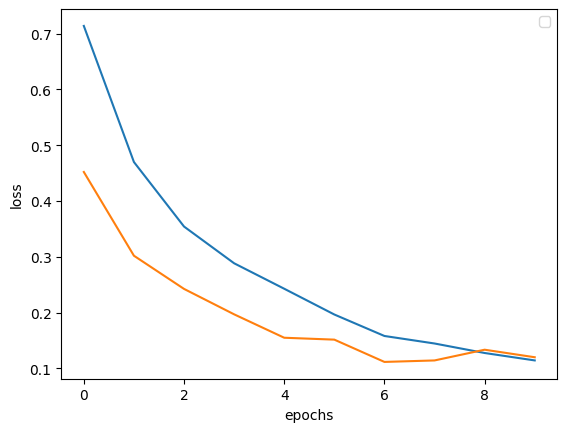

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


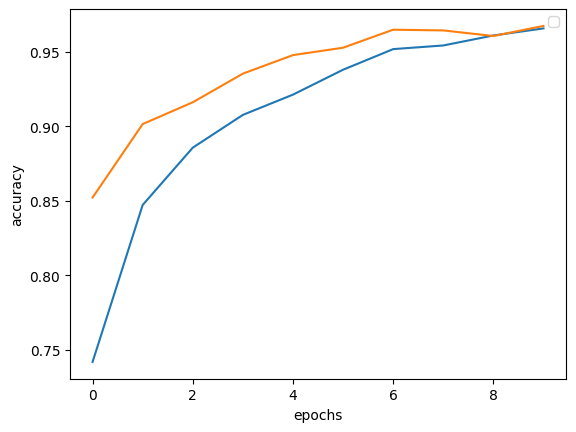

In [ ]:
import matplotlib.pyplot as plt

plt.plot(best_history.history["loss"], label="train")
plt.plot(best_history.history["val_loss"], label="val")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.title("The loss of each epoch")
plt.show()

plt.plot(best_history.history["accuracy"], label="train")
plt.plot(best_history.history["val_accuracy"] label="val")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.title("The accuracy of each epoch")
plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Best CNN Accuracy: 0.9226006191950464


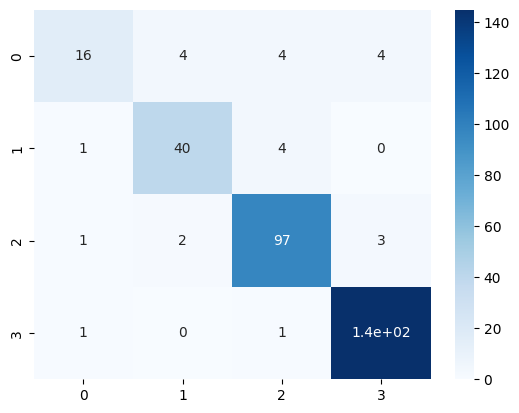

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = best.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_pred_classes, y_test)
sns.heatmap(cm, cmap="Blues", annot=True)

print(f"Best CNN Accuracy: {accuracy_score(y_pred_classes, y_test)}")

In [36]:
from sklearn.metrics import classification_report

report = classification_report(y_pred_classes, y_test, target_names=["top", "mid", "low", "wat"])
print(report)

              precision    recall  f1-score   support

         top       0.84      0.57      0.68        28
         mid       0.87      0.89      0.88        45
         low       0.92      0.94      0.93       103
         wat       0.95      0.99      0.97       147

    accuracy                           0.92       323
   macro avg       0.90      0.85      0.86       323
weighted avg       0.92      0.92      0.92       323

